In [1]:
"""
This is the Notebook for CS610 Group Project, using the data, hotel_bookings.csv after Data Slit, to train and test the model XGBoost, with fine-tuning of hyperparameters. 

"""

'\nThis is the Notebook for CS610 Group Project, using the data, hotel_bookings.csv after Data Slit, to train and test the model XGBoost, with fine-tuning of hyperparameters. \n\n'

In [ ]:
# #@title connect google drive

# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/SMU_MITB_AML_PRO/

In [2]:
pip install -r requirements.txt ## optuna included


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from re import VERBOSE
import optuna
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import tqdm
# import shap

from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor

RANDOM_STATE = 2025
VERBOSE = 2

/Users/hclee/Desktop/A_MITB/CS610 AML /Group_Project/SMU_AML_PROJ/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#@title load data from same directory
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

In [5]:
#@title Checking data after transformation 
X_hotel_data_raw = hotel_data.drop(['is_canceled'], axis=1)
y_hotel_data_raw = hotel_data['is_canceled'].astype(int)

xyp = XYPreprocessor()
X_hotel_data_processed, y_hotel_data_processed = xyp.fit_transform(X_hotel_data_raw, y_hotel_data_raw)

print(X_hotel_data_processed.shape)
print(y_hotel_data_processed.shape)

(87377, 99)
(87377,)


In [6]:
#@title Feature Engineering on Date: Combine year, month, and day columns into a single datetime column. Split into test and train/val sets

hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel_data['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split into test and train/val sets
test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Optional summary
print(f"Latest arrival date: {last_date.date()}")
print(f"Cutoff date for test set: {cutoff_date.date()}")
print(f"Train/Validation samples: {len(train_val_data)}")
print(f"Test samples: {len(test_data)}")

Latest arrival date: 2017-08-31
Cutoff date for test set: 2017-05-31
Train/Validation samples: 103505
Test samples: 15885


In [7]:
#@title Inspect hotel_data df
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [8]:
hotel_data.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016-08-28 16:39:45.727447808
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2015-07-01 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016-03-13 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016-09-06 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017-03-18 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-08-31 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,NaN


In [13]:
hotel_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date'],
      dtype='object')

In [32]:
#@title train-test split X,y_train and X,y_test
X_train_val_raw = train_val_data.drop(['is_canceled'], axis=1)
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(['is_canceled'], axis=1)
y_test_raw = test_data['is_canceled'].astype(int)

In [33]:
#@title Import Libraries for XGBoost

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import recall_score

In [34]:
#@title create class ClassifierModelwithOptuna (Modified for XGBoost)

# import shap  ## get feature importance for tree models (optional)

class ClassifierModelWithOptuna:
    def __init__(self, X, y, model_class, param_space_func, n_trials=20, n_splits=5, use_early_stopping=False, early_stopping_rounds=10):
        """
        model_class: e.g., XGBClassifier, LogisticRegression
        param_space_func: callable(trial) → dict of model kwargs
        use_early_stopping: bool, whether to use early stopping for XGBoost
        early_stopping_rounds: int, early stopping patience for XGBoost
        """
        self.X_raw = X # Store raw data
        self.y_raw = y # Store raw data
        self.model_class = model_class
        self.param_space_func = param_space_func
        self.n_trials = n_trials
        self.n_splits = n_splits
        self.use_early_stopping = use_early_stopping
        self.early_stopping_rounds = early_stopping_rounds

        self.best_model = None
        self.best_params = None
        self.study = None
        self.preprocessor = XYPreprocessor() # Initialize preprocessor once
        
        # Check if model is XGBoost for specific handling, like early stopping
        self.is_xgboost = hasattr(model_class, '__name__') and 'XGB' in str(model_class)

    def objective(self, trial):
        params = self.param_space_func(trial)
        model = self.model_class(**params)

        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=RANDOM_STATE)
        scores = []

        for train_idx, val_idx in skf.split(self.X_raw, self.y_raw):
            X_train_raw, X_val_raw = self.X_raw.iloc[train_idx], self.X_raw.iloc[val_idx]
            y_train_raw, y_val_raw = self.y_raw.iloc[train_idx], self.y_raw.iloc[val_idx]

            # Joint preprocessing of X and y
            preprocessor = XYPreprocessor()
            X_train, y_train = preprocessor.fit_transform(X_train_raw, y_train_raw)
            X_val, y_val = preprocessor.transform(X_val_raw, y_val_raw)

            # Train model with early stopping for XGBoost if enabled
            if self.is_xgboost and self.use_early_stopping:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    early_stopping_rounds=self.early_stopping_rounds,
                    verbose=False
                )
            else:
                model.fit(X_train, y_train)
            
            y_pred = model.predict_proba(X_val)[:, 1]
            scores.append(roc_auc_score(y_val, y_pred))

        return np.mean(scores)

    def optimize(self):

        pbar = tqdm.tqdm(total=self.n_trials, desc="Optimizing Trials")

        def tqdm_callback(study, trial):
            pbar.update(1)

        self.study = optuna.create_study(direction='maximize')
        self.study.optimize(self.objective, n_trials=self.n_trials, callbacks=[tqdm_callback])

        pbar.close()

        self.best_params = self.param_space_func(self.study.best_trial)
        self.best_model = self.model_class(**self.best_params)

        # Fit the final model on the preprocessed full training/validation data
        X_train_val_processed, y_train_val_processed = self.preprocessor.fit_transform(self.X_raw, self.y_raw)
        
        # Use early stopping for final model if XGBoost and enabled
        if self.is_xgboost and self.use_early_stopping:
            # Create a small validation set from training data for early stopping
            X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
                X_train_val_processed, y_train_val_processed, 
                test_size=0.1, random_state=RANDOM_STATE, stratify=y_train_val_processed
            )
            self.best_model.fit(
                X_train_es, y_train_es,
                eval_set=[(X_val_es, y_val_es)],
                early_stopping_rounds=self.early_stopping_rounds,
                verbose=False
            )
        else:
            self.best_model.fit(X_train_val_processed, y_train_val_processed)

        print("Best Parameters:", self.best_params)
        print("Best AUC Score:", self.study.best_value)

    def predict(self, X_test_raw, y_test_raw=None):
        X_test_processed, y_test_processed = self.preprocessor.transform(X_test_raw, y_test_raw)

        y_pred = self.best_model.predict(X_test_processed)
        y_prob = self.best_model.predict_proba(X_test_processed)[:, 1] if hasattr(self.best_model, 'predict_proba') else None

        if y_test_raw is not None:
            print("\nClassification Report:")
            print(classification_report(y_test_processed, y_pred, digits=4))

            if y_prob is not None:
                auc = roc_auc_score(y_test_processed, y_prob)
                recall = recall_score(y_test_processed, y_pred)
                print(f"AUC Score: {auc:.4f}")
                print(f"Recall Score: {recall:.4f}")

                # Plot ROC curve
                fpr, tpr, _ = roc_curve(y_test_processed, y_prob)
                plt.figure()
                plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
                plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve")
                plt.legend()
                plt.grid(True)
                plt.show()

        return y_pred

    def get_top_k_features(self, X_val_raw, y_val_raw=None, method='permutation', k=10):
        if self.best_model is None:
            print("No trained model found. Please run optimize() first.")
            return None

        X_val_processed, y_val_processed = self.preprocessor.transform(X_val_raw, y_val_raw)

        # Native XGBoost feature importance (NEW)
        if method == 'xgboost_native':
            if not self.is_xgboost:
                print("Native XGBoost importance only available for XGBoost models. Using permutation instead.")
                method = 'permutation'
            else:
                importances = self.best_model.feature_importances_
                feature_names = X_val_processed.columns if hasattr(X_val_processed, 'columns') else [f'feature_{i}' for i in range(X_val_processed.shape[1])]

                xgb_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)

                print(f"\nTop {k} features by XGBoost Native Importance (Gain):")
                return xgb_df.head(k)

        # Permutation importance (works for all models)
        if method == 'permutation':
            result = permutation_importance(
                self.best_model,
                X_val_processed,
                y_val_processed,
                scoring='f1',
                n_repeats=5,
                random_state=RANDOM_STATE)

            importances = result.importances_mean
            feature_names = X_val_processed.columns if hasattr(X_val_processed, 'columns') else [f'feature_{i}' for i in range(X_val_processed.shape[1])]

            perm_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"\nTop {k} features by Permutation Importance:")
            return perm_df.head(k)

        # SHAP importance (works for tree models, requires shap import)
        elif method == 'shap':
            try:
                import shap
                explainer = shap.Explainer(self.best_model, X_val_processed)
                shap_values = explainer(X_val_processed)
            except ImportError:
                print("SHAP not installed. Please install with: pip install shap")
                print("Falling back to native XGBoost importance if available, otherwise permutation.")
                return self.get_top_k_features(X_val_raw, y_val_raw, 
                                             method='xgboost_native' if self.is_xgboost else 'permutation', k=k)
            except Exception as e:
                print(f"Falling back to KernelExplainer due to: {e}")
                try:
                    background = shap.utils.sample(X_val_processed, 100)
                    explainer = shap.KernelExplainer(self.best_model.predict_proba, background)
                    shap_values = explainer.shap_values(X_val_processed)
                except:
                    print("SHAP failed. Using native XGBoost importance if available, otherwise permutation.")
                    return self.get_top_k_features(X_val_raw, y_val_raw, 
                                                 method='xgboost_native' if self.is_xgboost else 'permutation', k=k)

            # Handle shap_values for binary classification
            if isinstance(shap_values, list):  # binary classification case
                shap_vals = shap_values[1] if len(shap_values) > 1 else shap_values[0]
            else:
                shap_vals = shap_values.values

            abs_mean_shap = np.abs(shap_vals).mean(axis=0)
            feature_names = X_val_processed.columns if hasattr(X_val_processed, 'columns') else [f'feature_{i}' for i in range(X_val_processed.shape[1])]

            shap_df = pd.DataFrame({
                'feature': feature_names,
                'importance': abs_mean_shap
            }).sort_values('importance', ascending=False)

            print(f"\nTop {k} features by SHAP Importance:")
            return shap_df.head(k)

        else:
            raise ValueError("Method must be either 'permutation', 'shap', or 'xgboost_native'")

    def export_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        if self.best_model is None:
            print("No best model to export.")
            return

        joblib.dump(self.best_model, model_path)
        info = {
            'best_params': self.best_params,
            'best_score': float(self.study.best_value),
            'model_type': str(self.model_class),
            'is_xgboost': self.is_xgboost
        }
        with open(info_path, 'w') as f:
            json.dump(info, f, indent=2)

        print(f"Model saved to {model_path}")
        print(f"Info saved to {info_path}")

    def import_model(self, model_path='best_model.pkl', info_path='best_model_info.json'):
        self.best_model = joblib.load(model_path)
        with open(info_path, 'r') as f:
            info = json.load(f)
            self.best_params = info['best_params']
            if 'is_xgboost' in info:
                self.is_xgboost = info['is_xgboost']


    def improve_predict(self, X_test_raw, y_test_raw=None, threshold=0.5):
        """
    Make predictions with custom threshold
    
    Parameters:
    threshold: float, classification threshold (default 0.5)
              Lower values (0.3, 0.4) increase recall but may decrease precision
    """
        X_test_processed, y_test_processed = self.preprocessor.transform(X_test_raw, y_test_raw)

        # Get probabilities first
        y_prob = self.best_model.predict_proba(X_test_processed)[:, 1] if hasattr(self.best_model, 'predict_proba') else None
    
        # Apply custom threshold
        if y_prob is not None:
            y_pred = (y_prob >= threshold).astype(int)
        else:
            y_pred = self.best_model.predict(X_test_processed)

        if y_test_raw is not None:
            print(f"\nClassification Report (Threshold = {threshold}):")
            print(classification_report(y_test_processed, y_pred, digits=4))

            if y_prob is not None:
                auc = roc_auc_score(y_test_processed, y_prob)
                recall = recall_score(y_test_processed, y_pred)
                precision = precision_score(y_test_processed, y_pred)
                f1 = f1_score(y_test_processed, y_pred)
            
                print(f"AUC Score: {auc:.4f}")
                print(f"Recall Score: {recall:.4f}")
                print(f"Precision Score: {precision:.4f}")
                print(f"F1 Score: {f1:.4f}")
                print(f"Threshold Used: {threshold}")

                # Plot ROC curve
                fpr, tpr, _ = roc_curve(y_test_processed, y_prob)
                plt.figure(figsize=(10, 4))
            
                # ROC Curve
                plt.subplot(1, 2, 1)
                plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
                plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve")
                plt.legend()
                plt.grid(True)
            
                # Precision-Recall Curve
                plt.subplot(1, 2, 2)
                from sklearn.metrics import precision_recall_curve
                precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_processed, y_prob)
                plt.plot(recall_vals, precision_vals)
                plt.axvline(x=recall, color='red', linestyle='--', alpha=0.7, label=f'Current Recall={recall:.3f}')
                plt.axhline(y=precision, color='red', linestyle='--', alpha=0.7, label=f'Current Precision={precision:.3f}')
                plt.xlabel("Recall")
                plt.ylabel("Precision")
                plt.title(f"Precision-Recall Curve (Threshold={threshold})")
                plt.legend()
                plt.grid(True)
            
                plt.tight_layout()
                plt.show()

        return y_pred

In [35]:
#@title Define parameter search space for XGBoost
def xgb_param_space(trial):
    # Tree structure parameters
    max_depth = trial.suggest_categorical("max_depth", [3, 6, 10])
    min_child_weight = trial.suggest_categorical("min_child_weight", [1, 3, 7])
    
    # Learning parameters  
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.1, 0.2])
    n_estimators = trial.suggest_categorical("n_estimators", [100, 300, 500])
    
    # Regularization parameters
    reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.1, 1.0])  # L1 regularization
    reg_lambda = trial.suggest_categorical("reg_lambda", [1, 5, 10])   # L2 regularization
    
    # Sampling parameters
    subsample = trial.suggest_categorical("subsample", [0.7, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical("colsample_bytree", [0.7, 0.8, 1.0])
    
    # Class imbalance handling
    scale_pos_weight = trial.suggest_categorical("scale_pos_weight", [1, 2, 3])
    
    params = {
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "scale_pos_weight": scale_pos_weight,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": RANDOM_STATE,
        "n_jobs": -1  # Use all available cores
    }
    return params

In [36]:
#@title  Create XGBoost model 
xgb_model = ClassifierModelWithOptuna(
    X_train_val_raw, y_train_val_raw,
    XGBClassifier,
    xgb_param_space,  
    n_trials=30,
    use_early_stopping=True
)


In [37]:
#@title Search for best_params for XGBoost model. Takes more than 10 mins on CPU.  Skip if you already optimised.
xgb_model.optimize()

Optimizing Trials:   0%|          | 0/30 [00:00<?, ?it/s][I 2025-06-17 16:17:01,005] A new study created in memory with name: no-name-5d868c21-9e05-4e80-80c3-a89e59426988
/Users/hclee/Desktop/A_MITB/CS610 AML /Group_Project/SMU_AML_PROJ/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/hclee/Desktop/A_MITB/CS610 AML /Group_Project/SMU_AML_PROJ/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/hclee/Desktop/A_MITB/CS610 AML /Group_Project/SMU_AML_PROJ/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecat

Best Parameters: {'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.2, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'scale_pos_weight': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 2025, 'n_jobs': -1}
Best AUC Score: 0.9446275214225907


## Best_params for XGBoost from HyperParameter Tuning

- Best Parameters: {'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.2, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'scale_pos_weight': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 2025, 'n_jobs': -1}
- Best AUC Score: 0.9446275214225907


Classification Report:
              precision    recall  f1-score   support

           0     0.8507    0.7935    0.8211      8512
           1     0.6633    0.7451    0.7019      4649

    accuracy                         0.7764     13161
   macro avg     0.7570    0.7693    0.7615     13161
weighted avg     0.7845    0.7764    0.7790     13161

AUC Score: 0.8605
Recall Score: 0.7451


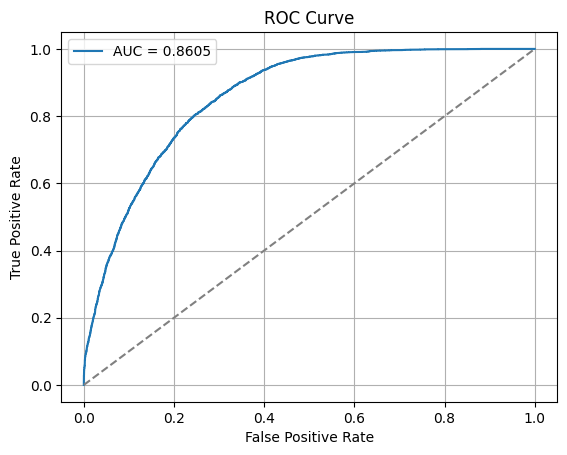

array([0, 0, 1, ..., 0, 0, 0])

In [38]:
#@title Evaluate XGBoost on Test-set

xgb_model.predict(X_test_raw, y_test_raw)

In [39]:
#@title Export the model
xgb_model.export_model()

Model saved to best_model.pkl
Info saved to best_model_info.json


In [40]:
#@title Import the model
xgb_model.import_model()
print(xgb_model.best_params)

{'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.2, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 1.0, 'colsample_bytree': 1.0, 'scale_pos_weight': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 2025, 'n_jobs': -1}


In [41]:
#@title Get top_K features, where k=10 

xgb_model.get_top_k_features(X_test_raw, y_test_raw, method='xgboost_native', k=10)


Top 10 features by XGBoost Native Importance (Gain):


,feature,importance
14,required_car_parking_spaces,0.227372
21,room_type_match,0.167382
98,agent_binned_Other,0.084680
93,agent_binned_7.0,0.065839
72,deposit_type_Non Refund,0.034511
42,market_segment_Online TA,0.034017
92,country_binned_PRT,0.033045
9,previous_cancellations,0.016890
15,total_of_special_requests,0.016106
47,distribution_channel_TA/TO,0.015256


## Conclusion: 
### AUC under ROC = 0.8605, and Recall-score on label_1 = 0.7451

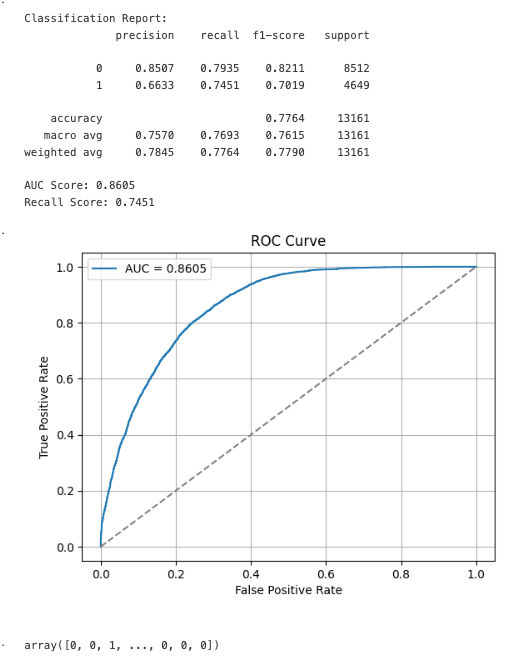

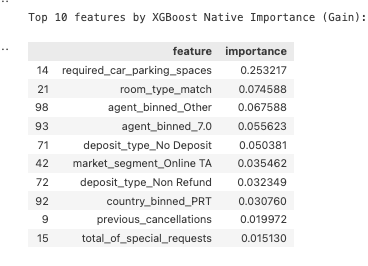


=== Threshold = 0.4 ===

Classification Report (Threshold = 0.4):
              precision    recall  f1-score   support

           0     0.8803    0.7390    0.8035      8512
           1     0.6307    0.8161    0.7115      4649

    accuracy                         0.7662     13161
   macro avg     0.7555    0.7775    0.7575     13161
weighted avg     0.7921    0.7662    0.7710     13161

AUC Score: 0.8605
Recall Score: 0.8161
Precision Score: 0.6307
F1 Score: 0.7115
Threshold Used: 0.4


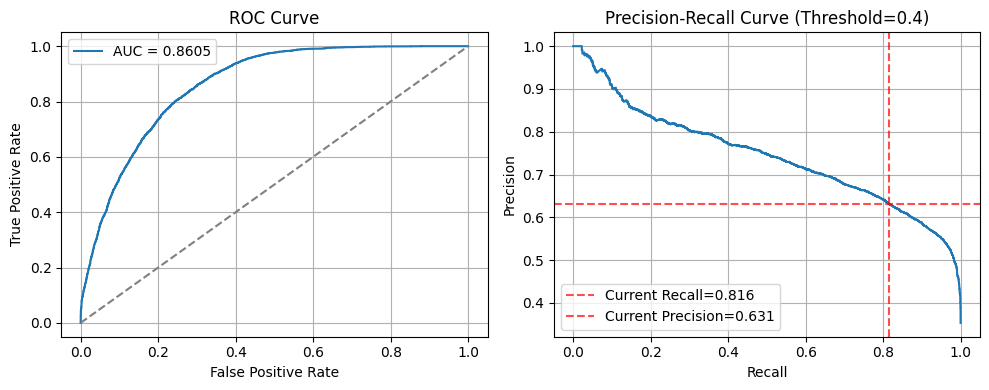


=== Threshold = 0.3 ===

Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0     0.9119    0.6738    0.7749      8512
           1     0.5959    0.8808    0.7109      4649

    accuracy                         0.7469     13161
   macro avg     0.7539    0.7773    0.7429     13161
weighted avg     0.8003    0.7469    0.7523     13161

AUC Score: 0.8605
Recall Score: 0.8808
Precision Score: 0.5959
F1 Score: 0.7109
Threshold Used: 0.3


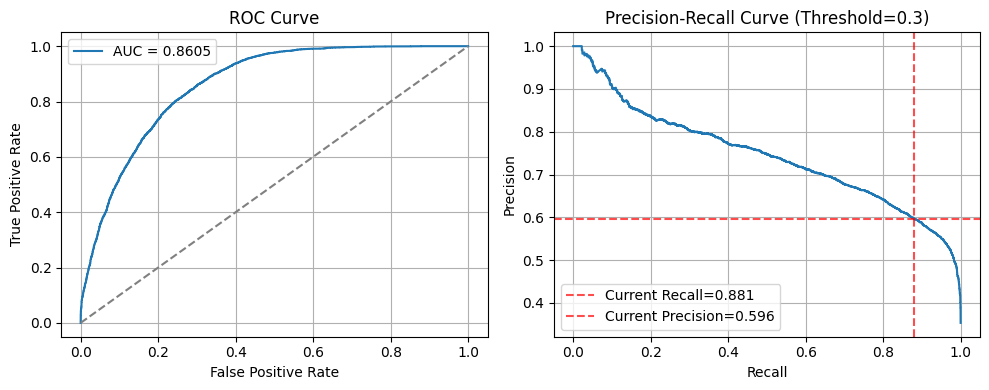

array([0, 1, 1, ..., 1, 0, 1])

In [43]:
#@title try different classification threshold
from sklearn.metrics import precision_score, f1_score, precision_recall_curve

print("\n=== Threshold = 0.4 ===") 
xgb_model.improve_predict(X_test_raw, y_test_raw, threshold=0.4)

print("\n=== Threshold = 0.3 ===")
xgb_model.improve_predict(X_test_raw, y_test_raw, threshold=0.3)

In [44]:
whos

Variable                            Type                         Data/Info
--------------------------------------------------------------------------
ClassifierModelWithOptuna           type                         <class '__main__.ClassifierModelWithOptuna'>
FunctionTransformer                 type                         <class 'sklearn.preproces<...>mer.FunctionTransformer'>
LogisticRegression                  type                         <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
Pipeline                            ABCMeta                      <class 'sklearn.pipeline.Pipeline'>
RANDOM_STATE                        int                          2025
StandardScaler                      type                         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
StratifiedKFold                     ABCMeta                      <class 'sklearn.model_sel<...>._split.StratifiedKFold'>
VERBOSE                             int                          2
XGBClassifier     